To define density peakes we first need to get the density of each point, starting from the dissimilratyi matrix.

We will use gaussian kernel density estimation, hence:
$$ \rho(x) = \sum\_{x_i} \exp (-\frac{d(x_i, x_j)^2}{d_c^2}) $$


In [1]:
import numpy as np


def density_i(i, D, d_c):
    # i: index of the point for which we want to compute the density, D the distance matrix
    # d_c is the radius

    values = (np.exp(-D[i, j] ** 2 / d_c**2) for j in range(D.shape[0]))

    # Convert the generator values to a numpy array and calculate the sum
    density_i = np.sum(np.fromiter(values, dtype=float))
    return density_i


def compute_density(D, d_c, X):
    # compute the density of each point of the dataset

    densities = np.zeros(D.shape[0])
    for i in range(D.shape[0]):
        densities[i] = density_i(i, D, d_c)

    # return the densities orderd in ascending order,
    # the list of indexes for the sorting
    # return X, sorted wrt to indexes given by argsorting densities
    # return D, sorted wrt to indexes given by argsorting densities
    sorted_indexes = np.argsort(densities)[::-1]
    densities = densities[sorted_indexes]
    sorted_D = D[sorted_indexes]
    sorted_X = X[sorted_indexes]
    return densities, sorted_indexes, sorted_D, sorted_X

Then we need to compute deltaas such:

- we compute the density for each datapoint.
- we rank datapoint wrt their density
- we compute delta for each point: the delta for a point is the minimum distance between that point and the points which has higher density than it.


In [2]:
def compute_delta(sorted_D):
    deltas = np.zeros(sorted_D.shape[0])
    for i in range(1, sorted_D.shape[0]):
        deltas[i] = np.min(sorted_D[:i, i])
    deltas[0] = np.max(deltas) + (5 / 100 * np.max(deltas))
    return deltas

In [3]:
X = np.loadtxt("../Datasets/Aggregation.txt")
labels = X[:, 2]
X = X[:, :2]

In [4]:
from scipy.spatial.distance import cdist

D = cdist(X, X, metric="euclidean")

In [5]:
densities, sorted_indexes, sorted_D, sorted_X = compute_density(D=D, d_c=1.4, X=X)
deltas = compute_delta(sorted_D=sorted_D)

1% of the data is 7.88 \
2% of data is 15.76 \
We want d_c s.t. np.mean(densities) lies between 7.88 and 15.76


In [6]:
np.mean(densities)

9.550002922389952

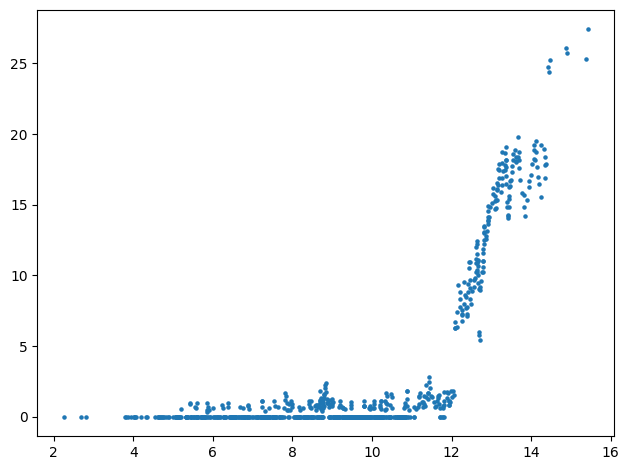

In [7]:
from matplotlib import pyplot as plt

plt.scatter(densities, deltas, s=5)
"""for i, (density, delta) in enumerate(zip(densities, deltas)):
    plt.text(density, delta, str(i), fontsize=10, ha='center', va='bottom')"""
plt.tight_layout()

Can clearly see the 7 outlieres


Now, recover the point that correspond to the highest value of delta. Those will be the centers


In [8]:
def get_points_with_k_highest_delta(X, sorted_indexes, sorted_D, k):
    # Compute the delta values for the sorted distance matrix
    deltas = compute_delta(sorted_D)

    # Sort the indices based on delta values in descending order
    sorted_delta_indices = np.argsort(deltas)[::-1]

    # Get the indices of the top k points with the highest delta values
    top_k_indices = sorted_delta_indices[:k]

    # Get the corresponding original indices of the points
    original_indices_with_top_k_delta = sorted_indexes[top_k_indices]

    # Retrieve the points with the top k highest delta values from the original dataset
    points_with_top_k_delta = X[original_indices_with_top_k_delta]

    return points_with_top_k_delta


points_with_k_highest_delta = get_points_with_k_highest_delta(
    X=X, sorted_indexes=sorted_indexes, sorted_D=sorted_D, k=7
)

In [9]:
points_with_k_highest_delta

array([[ 6.75,  3.55],
       [ 6.75,  3.2 ],
       [ 6.2 ,  3.2 ],
       [ 6.65,  3.8 ],
       [18.4 ,  4.6 ],
       [15.45,  9.7 ],
       [17.3 ,  4.8 ]])

In [16]:
def recover(deltas, k, sorted_indexes):
    # k is the number of outliers
    sorted_deltas = np.argsort(deltas)[::-1][:k]

    indices = np.where(np.isin(sorted_indexes, sorted_deltas))
    centers = sorted_X[indices]
    return centers


centers = recover(deltas=deltas, k=7, sorted_indexes=sorted_indexes)

In [17]:
np.argsort(deltas)[::-1][:7]

array([0, 3, 2, 1, 4, 6, 5])

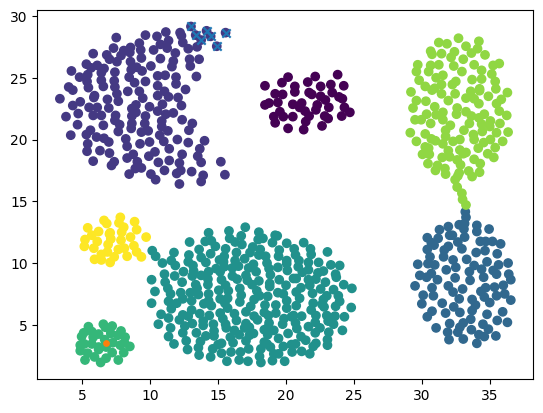

In [18]:
# centers = X[np.argsort(deltas)[::-1][:7]]
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], marker="x")
plt.scatter(X[sorted_indexes[0]][0], X[sorted_indexes[0]][1], s=15)
plt.show()